In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pylab as plt
%matplotlib inline

import time
import os
import shutil # for copying checkpoint to "last"

from audioDataLoader.mulaw import mu_law_encode, mu_law_decode
from audioDataLoader.audio_dataset import AudioDatasetConfig, MuLawAudioDataset2
from torch.utils.data import DataLoader

import model.gru_audio_model

### Data Params  
<a id="dataparams"></a>

These parameters are pickled to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* PRovide a record of the parameters that allow reproducing results. 

In [2]:
resume_checkpoint= None # "./output/20250806_162914/"
sourcedatadir='./data/nsynth.64.76.dl_new'

params = dict(
    # Read/write directory of data & parameter files
    #*************************************
    sample_rate=16000,
    runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
    
    datadir = sourcedatadir,
    paramdir = sourcedatadir,

    savemodel = True,
    savemodel_interval = 20, #in units of epochs
    savemodeldir = os.getcwd() + '/output', #default saving directory for models and the parameterization
    
    batches_per_epoch = 100, #1000,  #10000, #max number batches of steps per epoch (typically num_epochs=1)
    batch_size = 256, #256,
    num_epochs = 80,

    # Training parameters
    #*************************************
    noise=.1,
    seqLen = 128, 
    stride = 1,
    
    lr = 0.005,
    props={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
    
    # Model parameters
    input_size = 1,
    hiddenSize = 32, #100,
    nLayers = 6,
    output_size = 256,
    dropout = 0.1
)

### Run Params 

In [3]:
sr = params['sample_rate']

log_interval = 1 # units of epochs
visualize_interval = log_interval # units of epochs

#Generation parameters
#*************************************
max_length = params['seqLen']*3

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
params

{'sample_rate': 16000,
 'runTimeStamp': '2025-08-06_17-26-38',
 'datadir': './data/nsynth.64.76.dl_new',
 'paramdir': './data/nsynth.64.76.dl_new',
 'savemodel': True,
 'savemodel_interval': 20,
 'savemodeldir': '/home/lonce/working/RNNControl2/output',
 'batches_per_epoch': 100,
 'batch_size': 256,
 'num_epochs': 80,
 'noise': 0.1,
 'seqLen': 128,
 'stride': 1,
 'lr': 0.005,
 'props': {'instID': (1, 2), 'a': (0, 1), 'p': (64.0, 76.0)},
 'input_size': 1,
 'hiddenSize': 32,
 'nLayers': 6,
 'output_size': 256,
 'dropout': 0.1}

In [4]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def inputcoding(samp) :
    return mu_law_encode(np.array(samp))/255.

def index2float(topi) :
    return(mu_law_decode(topi[0][0]).cpu().numpy())


In [5]:

#--- model settings ----#
model_config = model.gru_audio_model.GRUAudioConfig (
    input_size = params['input_size'],
    cond_size = len(params['props']),
    hidden_size = params['hiddenSize'],
    num_layers = params['nLayers'],
    output_size = 256,  #mu-law quantization levels
    dropout = params['dropout']
)

# ---- Training Settings ----
data_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs=params['props'],
   add_noise= False if params['noise'] == 0 else True,   # Whether to add white noise
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=True
)

# ---- Generation Settings ----
testdata_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs=params['props'],
   add_noise= False,                        # no noise for testing and priming
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=False
)

# === Dataset and Loader ===
adataset = MuLawAudioDataset2(data_config)
train_loader = DataLoader(adataset,
                             batch_size=params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             drop_last=True)

testdataset = MuLawAudioDataset2(testdata_config)
test_loader = DataLoader(testdataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=4,
                            drop_last=True)
   

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

size of dataset is 10366720
no. of batches per epoch is 100
batchsize id  is 256


size of dataset is 10366720
no. of batches per epoch is 100
batchsize id  is 256
rand_sample: idx=3191223
rand_sample: file_idx=80
rand_sample: start_pos=1463, end_pos=1592
torch.Size([129])


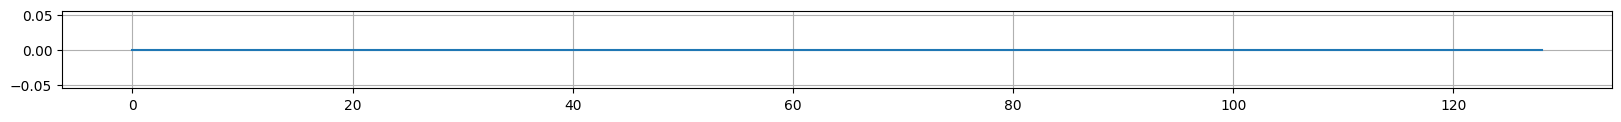

/tmp/ipykernel_488166/3278478625.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return mu_law_encode(np.array(samp))/255.


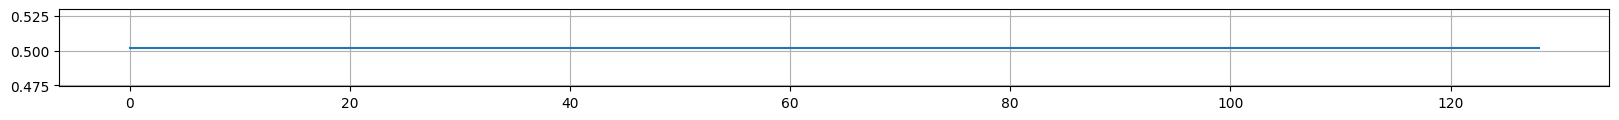

Do it! 2025-08-06 17:26:39
bat num 0 at time 2025-08-06 17:26:40
x_audio_seq.shape = torch.Size([1, 128, 4])
y_target_seq.shape = torch.Size([1, 128, 1])
bat num 1 at time 2025-08-06 17:26:40
x_audio_seq.shape = torch.Size([1, 128, 4])
y_target_seq.shape = torch.Size([1, 128, 1])
finished at 2025-08-06 17:26:40


In [6]:
# show stuff

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = inputcoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()


n_batches = 1
print("Do it! {}".format(mydate()))
for bat, (x_audio_seq, y_target_seq) in enumerate(test_loader):
    print("bat num {} at time {}".format(bat, mydate()))
    print(f"x_audio_seq.shape = {x_audio_seq.shape}") 
    print(f"y_target_seq.shape = {y_target_seq.shape}")
    if bat >= n_batches :
        break;
print("finished at {}".format(mydate()))

# print(f"x_audio_seq[0,:,0] seq is {x_audio_seq[0,:,0]}")
# print(f"x_audio_seq[0,:,1] seq is {x_audio_seq[0,:,1]}")
# print(f"x_audio_seq[0,:,2] seq is {x_audio_seq[0,:,2]}")
# print(f"x_audio_seq[0,:,3] seq is {x_audio_seq[0,:,3]}")
# print(f"y_target_seq[0,:] seq is {y_target_seq[0,:].squeeze(-1)}")


In [7]:
# Define the training cycle (100% teacher forcing for now)
#*************************************

def train(model,epoch):


 model.train() #put in training mode
 ave_loss_over_steps = 0

 ave_loss_over_steps = 0

 debug_seqs=0

 for batch_num, (inp, target) in enumerate(train_loader):

     # if batch_num==0:
     #     print(f"train() - inp[:,:,0] - Min: {torch.min(inp[:,:,0])}, Max: {torch.max(inp[:,:,0])}, Average: {torch.mean(inp[:,:,0])}")

     debug_seqs=debug_seqs+len(inp) # summing the batch length for each batch_num

     inp, target = inp.to(device), target.to(device)
     # Forward + Backward + Optimize
     hidden = model.init_hidden(params['batch_size'])
     optimizer.zero_grad()
     loss = 0

     #print(f" inp[0,127,0] (B,T,p) is {inp[0,127,0]}")

     # iterate through the SEQUENCE
     for i in range(params['seqLen']):
         outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
         loss += criterion(outputs, torch.squeeze(target[:,i],1))
         #print(f"timestep {i} target is {torch.squeeze(target[:,i],1)}")

     loss.backward()
     optimizer.step()

     ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
     ave_loss_over_steps += ave_loss_per_sample


     if batch_num>=(params['batches_per_epoch']-1):
         break

 print(f"Finished epoch number {epoch} with a total of {debug_seqs} debug_seqs")


 if (epoch+1) % log_interval == 0:
     print(f" time: {datetime.now()}, epoch {epoch},  Loss: {ave_loss_per_sample:.4f}")
     list_of_losses.append(ave_loss_per_sample)
     writer.add_scalar("Loss/train", ave_loss_per_sample, epoch)

 if (epoch+1) % visualize_interval == 0:
     #result = generate(model,max_length)
     result = newgen(model,max_length)
     plt.figure(figsize=(20,1))
     plt.plot(np.arange(len(result)), result) #just print one example from the batch
     plt.show()
     model.train() #put model back to training mode


    # overwrite the last, and save a numbered checkpoint
 if (epoch + 1) % params['savemodel_interval'] == 0:
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    
    # Save numbered checkpoint
    numbered_path = os.path.join(f"{out_dir}/checkpoints", f"checkpoint_{epoch}.pt")
    torch.save(checkpoint_data, numbered_path)
    
    # Copy to "last" (much faster than saving twice)
    last_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
    shutil.copy2(numbered_path, last_path)
    
    print(f"Saved checkpoint at epoch {epoch+1}")

In [8]:
# ---- Create Output Folders ----
if resume_checkpoint != None:
    out_dir = resume_checkpoint
else:
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(params['savemodeldir'], run_timestamp)
    os.makedirs(out_dir, exist_ok=True)

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(f"{out_dir}/checkpoints", exist_ok=True)
    os.makedirs(f"{out_dir}/tensorboard", exist_ok=True)


# ---- Save Config ----
#machine readable
torch.save({
    "model_config": model_config,
    "data_config": data_config
}, f"{out_dir}/config.pt")

#human readable
with open(f"{out_dir}/config.txt", "w") as f: 
    f.write("params = " + repr(params) + "\\n")
    f.write("model_config = " + repr(model_config) + "\\n")
    f.write("data_config = " + repr(data_config) + "\\n")

In [9]:
# this is for visualizing learning be showing one example of a generated sequence.
# the model is warmed up with a random sequence from the data set and it's corresponding param vector
from inference import run_inference

def newgen(model,max_length):
    p_inp, target = next(iter(test_loader))
    x=p_inp[:,:,0].squeeze(0) # raw audio of length sequence_length
    c=c_extended = p_inp[:,:,1:].squeeze(0).repeat_interleave(3, dim=0)  # Shape: [3*sequence_length, V]  
    gen = run_inference(model, c, x, top_n=3, temperature=1.0)
    return np.concatenate([x, gen]) #concatenated the warm up sequence with the genegenerated


<a href="#dataparams">Go To Data Params</a>

In [10]:

rnn = model.gru_audio_model.RNN(model_config).to(device)
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

start_epoch=0

if resume_checkpoint:
    checkpoint_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
    assert os.path.exists(checkpoint_path), f"File {checkpoint_path} does not exist"
    checkpoint = torch.load(checkpoint_path)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")

writer = SummaryWriter(log_dir=f"{out_dir}/tensorboard")

In [11]:
num_trainable_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")

Trainable parameters: 46624


2025-08-06 17:26:40 Starting training...
Finished epoch number 0 with a total of 25600 debug_seqs
 time: 2025-08-06 17:26:52.134398, epoch 0,  Loss: 5.0828
Starting inference...
Generating 384 audio samples...
Inference complete.


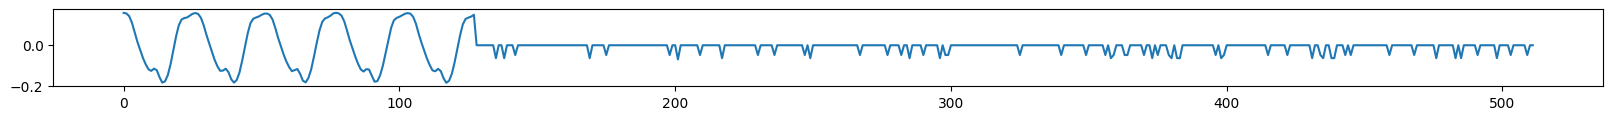

In [ ]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(start_epoch, start_epoch+params['num_epochs']):
    train(rnn,epoch)
writer.close()
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))


torch.save({
            'epoch': epoch,
            'model_state_dict': rnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
print(f"Saved checkpoint at epoch {epoch+1}")

In [ ]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)
plt.show()  # This will actually display the plot

In [ ]:
list_of_losses